In [1]:
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from torch_geometric.utils import add_self_loops

dataset_name = 'Cora'
split = "public"
dataset = Planetoid(root='/tmp/Cora', name=dataset_name, split=split)
dataset.transform = T.NormalizeFeatures()

features =  dataset[0].x
y =  dataset[0].y

test =  dataset[0].test_mask
train = dataset[0].train_mask
val =  dataset[0].val_mask

edge_index = dataset[0].edge_index 
edge_index = add_self_loops(edge_index)[0]

In [2]:
data = dataset[0]
data

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [3]:
from torch_geometric.transforms.largest_connected_components import LargestConnectedComponents
lc = LargestConnectedComponents()
lc(data)

Data(x=[2485, 1433], edge_index=[2, 10138], y=[2485], train_mask=[2485], val_mask=[2485], test_mask=[2485])

In [4]:
import torch
import torch.nn.functional as F


tensor([[1, 0, 0,  ..., 0, 0, 0],
        [0, 1, 0,  ..., 0, 0, 0],
        [0, 0, 1,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 0, 1, 0],
        [0, 0, 0,  ..., 0, 0, 1]])

In [5]:
import sys
 
sys.path.insert(0, "../")

from EnsembleFramework import Framework

In [123]:
def user_function(kwargs):
    return torch.nn.functional.normalize(kwargs["original_features"] + kwargs["summed_neighbors"], p=2.0, dim = 1)

hops_list = torch.arange(20).tolist()
framework = Framework([user_function for i in hops_list], 
                         hops_list=hops_list, ## to obtain best for local neighborhood
                         clfs=[],
                         gpu_idx=0,
                         handle_nan=0.0,
                        attention_configs=[None for i in hops_list])

In [124]:
label_features = F.one_hot(y).type(torch.float)
label_prop_features = framework.get_features(label_features,#label_features
                     edge_index,
                     torch.ones_like(y).type(torch.bool),False)

In [125]:
import pandas as pd
from IPython.display import display, HTML

means = []
medians = []
mins = []

for i, hop in enumerate(hops_list):
    print(hop)
    purity = torch.gather(label_prop_features[i].cpu(),1,y.unsqueeze(1)).squeeze(1) / torch.sum(label_prop_features[i].cpu(), 1)
    means.append(purity.mean())
    medians.append(torch.median(purity))
    mins.append(purity.min())
    display(HTML(pd.DataFrame(purity.numpy()).describe().to_html()))

0


,0
count,2708.0
mean,1.0
std,0.0
min,1.0
25%,1.0
50%,1.0
75%,1.0
max,1.0


1


,0
count,2708.000000
mean,0.895007
std,0.171929
min,0.222222
25%,0.800000
50%,1.000000
75%,1.000000
max,1.000000


2


,0
count,2708.000000
mean,0.856546
std,0.182011
min,0.239841
25%,0.749533
50%,0.948326
75%,1.000000
max,1.000000


3


,0
count,2708.000000
mean,0.828914
std,0.193798
min,0.187800
25%,0.707072
50%,0.915710
75%,0.989887
max,1.000000


4


,0
count,2708.000000
mean,0.809964
std,0.197928
min,0.183777
25%,0.679325
50%,0.884522
75%,0.980309
max,1.000000


5


,0
count,2708.000000
mean,0.795171
std,0.200896
min,0.167922
25%,0.657291
50%,0.862461
75%,0.970393
max,1.000000


6


,0
count,2708.000000
mean,0.783590
std,0.202537
min,0.164269
25%,0.639135
50%,0.845047
75%,0.961606
max,1.000000


7


,0
count,2708.000000
mean,0.774221
std,0.203685
min,0.159357
25%,0.629670
50%,0.829614
75%,0.954843
max,1.000000


8


,0
count,2708.000000
mean,0.766575
std,0.204445
min,0.157441
25%,0.620848
50%,0.818537
75%,0.947563
max,1.000000


9


,0
count,2708.000000
mean,0.760256
std,0.204992
min,0.155684
25%,0.611777
50%,0.809057
75%,0.941403
max,1.000000


10


,0
count,2708.000000
mean,0.754999
std,0.205383
min,0.154794
25%,0.604980
50%,0.802035
75%,0.936305
max,1.000000


11


,0
count,2708.000000
mean,0.750598
std,0.205674
min,0.154114
25%,0.599396
50%,0.795343
75%,0.931540
max,1.000000


12


,0
count,2708.000000
mean,0.746895
std,0.205893
min,0.153727
25%,0.595070
50%,0.789369
75%,0.927595
max,1.000000


13


,0
count,2708.000000
mean,0.743768
std,0.206061
min,0.153461
25%,0.590746
50%,0.784092
75%,0.923920
max,1.000000


14


,0
count,2708.000000
mean,0.741117
std,0.206192
min,0.153308
25%,0.587693
50%,0.779711
75%,0.920830
max,1.000000


15


,0
count,2708.000000
mean,0.738865
std,0.206296
min,0.153215
25%,0.584690
50%,0.776745
75%,0.918090
max,1.000000


16


,0
count,2708.000000
mean,0.736946
std,0.206379
min,0.153167
25%,0.582034
50%,0.774638
75%,0.915648
max,1.000000


17


,0
count,2708.000000
mean,0.735308
std,0.206448
min,0.153147
25%,0.579557
50%,0.773068
75%,0.913867
max,1.000000


18


,0
count,2708.000000
mean,0.733907
std,0.206504
min,0.153146
25%,0.577357
50%,0.771262
75%,0.912077
max,1.000000


19


,0
count,2708.000000
mean,0.732706
std,0.206552
min,0.153156
25%,0.576394
50%,0.769724
75%,0.910702
max,1.000000


Text(0, 0.5, 'Purity')

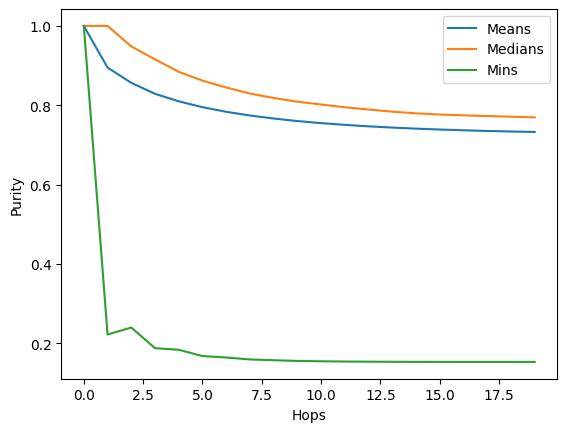

In [126]:
import matplotlib.pyplot as plt

plt.plot(means)
plt.plot(medians)
plt.plot(mins)
plt.legend(["Means","Medians", "Mins"])
plt.xlabel("Hops")
plt.ylabel("Purity")

In [127]:
uniqueness_features = F.one_hot(torch.arange(y.shape[0])).type(torch.float) ## test unqiueness of propagation
uniqueness_prop_features = framework.get_features(uniqueness_features,#label_features
                     edge_index,
                     torch.ones_like(y).type(torch.bool),False)

In [128]:
import pandas as pd
from IPython.display import display, HTML

means = []
medians = []
mins = []

for i, hop in enumerate(hops_list):
    print(hop)
    influence_init_node = torch.gather(uniqueness_prop_features[i].cpu(),1, torch.arange(y.shape[0]).unsqueeze(1)).squeeze(1) / torch.sum(uniqueness_prop_features[i].cpu(), 1)
    means.append(influence_init_node.mean())
    medians.append(torch.median(influence_init_node))
    mins.append(influence_init_node.min())
    display(HTML(pd.DataFrame(influence_init_node.numpy()).describe().to_html()))

0


,0
count,2708.0
mean,1.0
std,0.0
min,1.0
25%,1.0
50%,1.0
75%,1.0
max,1.0


1


,0
count,2708.000000
mean,0.416506
std,0.153212
min,0.011765
25%,0.285714
50%,0.400000
75%,0.500000
max,0.666667


2


,0
count,2708.000000
mean,0.284051
std,0.139379
min,0.076283
25%,0.181605
50%,0.246912
75%,0.353204
max,0.635749


3


,0
count,2708.000000
mean,0.215128
std,0.135532
min,0.040497
25%,0.119821
50%,0.172470
75%,0.261251
max,0.634062


4


,0
count,2708.000000
mean,0.181623
std,0.134912
min,0.036246
25%,0.092307
50%,0.136948
75%,0.218114
max,0.633979


5


,0
count,2708.000000
mean,0.158329
std,0.134806
min,0.029497
25%,0.074238
50%,0.110895
75%,0.183165
max,0.633975


6


,0
count,2708.000000
mean,0.142714
std,0.134704
min,0.024131
25%,0.062257
50%,0.094474
75%,0.160994
max,0.633975


7


,0
count,2708.000000
mean,0.130900
std,0.134788
min,0.020296
25%,0.053946
50%,0.082264
75%,0.142204
max,0.633975


8


,0
count,2708.000000
mean,0.121865
std,0.134872
min,0.017688
25%,0.047324
50%,0.072956
75%,0.130369
max,0.633975


9


,0
count,2708.000000
mean,0.114632
std,0.134998
min,0.015714
25%,0.042579
50%,0.066266
75%,0.120200
max,0.633975


10


,0
count,2708.000000
mean,0.108747
std,0.135127
min,0.014236
25%,0.038266
50%,0.060392
75%,0.110123
max,0.633975


11


,0
count,2708.000000
mean,0.103852
std,0.135264
min,0.013064
25%,0.035056
50%,0.055611
75%,0.102656
max,0.633975


12


,0
count,2708.000000
mean,0.099727
std,0.135399
min,0.012129
25%,0.032419
50%,0.051712
75%,0.095873
max,0.633975


13


,0
count,2708.000000
mean,0.096206
std,0.135532
min,0.011359
25%,0.030083
50%,0.048355
75%,0.090725
max,0.633975


14


,0
count,2708.000000
mean,0.093168
std,0.135658
min,0.010719
25%,0.028175
50%,0.045332
75%,0.085958
max,0.633975


15


,0
count,2708.000000
mean,0.090525
std,0.135779
min,0.010175
25%,0.026631
50%,0.042786
75%,0.081920
max,0.633975


16


,0
count,2708.000000
mean,0.088207
std,0.135893
min,0.009513
25%,0.025292
50%,0.040434
75%,0.077840
max,0.633975


17


,0
count,2708.000000
mean,0.086160
std,0.135999
min,0.008953
25%,0.024041
50%,0.038515
75%,0.074202
max,0.633975


18


,0
count,2708.000000
mean,0.084342
std,0.136098
min,0.008482
25%,0.022996
50%,0.036744
75%,0.071085
max,0.633975


19


,0
count,2708.000000
mean,0.082718
std,0.136190
min,0.008081
25%,0.022038
50%,0.035314
75%,0.068527
max,0.633975


Text(0, 0.5, 'Influence init node')

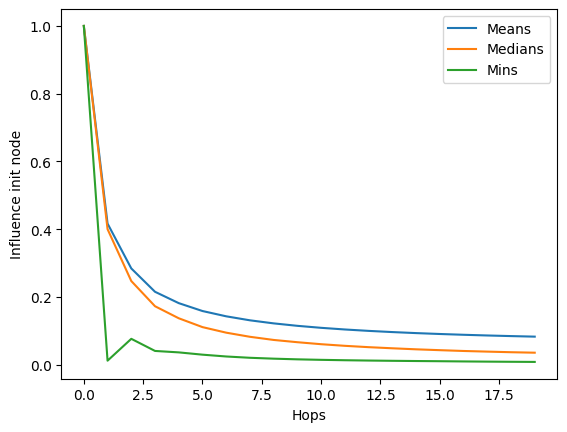

In [141]:
import matplotlib.pyplot as plt

plt.plot(means)
plt.plot(medians)
plt.plot(mins)
plt.legend(["Means","Medians", "Mins"])
plt.xlabel("Hops")
plt.ylabel("Influence init node")

In [131]:
prop_features = framework.get_features(features,#label_features
                     edge_index,
                     torch.ones_like(y).type(torch.bool),False)

In [140]:
for i, hop in enumerate(hops_list):
    print(torch.std(prop_features[i], dim = 1))

tensor([0.0088, 0.0055, 0.0060,  ..., 0.0062, 0.0070, 0.0073], device='cuda:0')
tensor([0.0261, 0.0260, 0.0259,  ..., 0.0263, 0.0260, 0.0260], device='cuda:0')
tensor([0.0260, 0.0259, 0.0254,  ..., 0.0263, 0.0259, 0.0257], device='cuda:0')
tensor([0.0258, 0.0257, 0.0253,  ..., 0.0263, 0.0257, 0.0256], device='cuda:0')
tensor([0.0256, 0.0256, 0.0250,  ..., 0.0263, 0.0256, 0.0254], device='cuda:0')
tensor([0.0255, 0.0255, 0.0249,  ..., 0.0263, 0.0255, 0.0253], device='cuda:0')
tensor([0.0253, 0.0253, 0.0248,  ..., 0.0263, 0.0254, 0.0252], device='cuda:0')
tensor([0.0252, 0.0252, 0.0247,  ..., 0.0263, 0.0252, 0.0251], device='cuda:0')
tensor([0.0251, 0.0251, 0.0246,  ..., 0.0263, 0.0251, 0.0250], device='cuda:0')
tensor([0.0250, 0.0250, 0.0245,  ..., 0.0263, 0.0250, 0.0249], device='cuda:0')
tensor([0.0249, 0.0249, 0.0244,  ..., 0.0263, 0.0250, 0.0248], device='cuda:0')
tensor([0.0248, 0.0248, 0.0244,  ..., 0.0263, 0.0249, 0.0247], device='cuda:0')
tensor([0.0248, 0.0248, 0.0243,  ..., 0.

tensor([0.0088, 0.0055, 0.0060,  ..., 0.0062, 0.0070, 0.0073], device='cuda:0')